# Equity Valuation

Create model for equities that, based on
* Balance Sheet (Revenue + Profit)
* INterest Rates + FX
* Market situation

Explains and predicts prices!


First, based on revenue projection, for each point in time calculate the implicit discount factor as per DCF method. Compare this to actual interest rates (+ expectations)

Estimate yield curves for DCF!


Revenue estimates:
* During Q1, there are alredy forecasts of Q2 - with some indication of uncertainty (lower, upper). Need to take these values as guidance for revenue forecasting!
* Quarterly data exhibit seasonality! Year-on-Year change needs to represents growth rate, but quarterly rate of changes need to be adjusted!!!
    * For each set of 8 data points: sum(1:4) / sum(5:8) == growth rate -> calculate as rolling window, such that there is always !! one !! unkown quarer

## Nice websites

* https://site.financialmodelingprep.com/discounted-cash-flow-model/MSFT

In [282]:
# Select few stocks: Microsoft, Apple, etc.
# Some good performers, and some bad performers.
# -> Maybe Top 10 companies in 2000? LIke Exxon, etc.

# TODO: Where to get revenue and number of shares data from? ideally yearly / quarterly for the last 5-10 years ???

In [283]:
# Check macrotrends.net
# https://www.macrotrends.net/stocks/charts/NFLX/netflix/income-statement?freq=Q
# -> NO programmatic access allowed! Data from zack investment research

# -> Quandl?

# -> PROBLEM: Most providers (even at 1.200USD / year) provide 5 year history only and sometimes even less for quaterly data
# -> MAYBE buy that later on! For development of code, that is too much!

In [284]:
import pandas as pd
import numpy as np

import yfinance as yf

from datetime import datetime, timedelta


import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [285]:
# Import fundamentals

file_fundamentals = "C:/Users\phili\OneDrive\GitHub\Portfolio_Management\Data_Fundamentals.xlsx"

fundamentals = pd.read_excel(file_fundamentals, sheet_name=None, skiprows=12, nrows=23)
fundamentals.keys()

dict_keys(['NFLX', 'MSFT', 'AAPL', 'KO', 'AMZN', 'PEP', 'GOOG', 'JNJ', 'BABA', 'JPM', 'LIN', 'MCD', 'META', 'NVDA', 'PANW', 'PYPL', 'SBUX', 'TSLA', 'V', 'WMT', 'XOM'])

In [286]:
# Get prices

date_start = '2008-12-01'
date_end = datetime.today()

symbols = fundamentals.keys()
symbols = ' '.join(symbols)

data_prices = yf.download(tickers = symbols, interval = "1d", start = date_start, end = date_end, group_by = 'ticker')

[*********************100%***********************]  21 of 21 completed


In [287]:
# Get interest rates

tr_symbols = ['^TNX', '^FVX', '^TYX']
tr_symbols = ' '.join(tr_symbols)

data_tr = yf.download(tickers = tr_symbols, interval = "1d", start = date_start, end = date_end, group_by = 'ticker')

[*********************100%***********************]  3 of 3 completed


In [288]:
# Rename columns
data_tr = data_tr.rename(columns={'^TYX': 'TR_30Y', '^TNX': 'TR_10Y', '^FVX': 'TR_5Y'})

data_tr.tail()

TR_10Y                                       TR_30Y                \
             Open   High    Low  Close Adj Close Volume   Open   High    Low   
Date                                                                           
2022-06-15  3.383  3.448  3.354  3.395     3.395      0  3.377  3.459  3.358   
2022-06-16  3.439  3.450  3.307  3.307     3.307      0  3.442  3.472  3.357   
2022-06-17  3.212  3.313  3.197  3.239     3.239      0  3.293  3.334  3.246   
2022-06-21  3.283  3.317  3.258  3.307     3.307      0  3.355  3.395  3.335   
2022-06-22  3.201  3.205  3.126  3.154     3.154      0  3.287  3.290  3.228   

                                    TR_5Y                                 \
            Close Adj Close Volume   Open   High    Low  Close Adj Close   
Date                                                                       
2022-06-15  3.413     3.413      0  3.485  3.568  3.412  3.472     3.472   
2022-06-16  3.362     3.362      0  3.522  3.522  3.363  3.377     3.377   
2022-06-17  3.294     3.294      0  3.289  3.425  3.282  3.340     3.340   
2022-06-21  3.390     3.390      0  3.376  3.399  3.351  3.379     3.379   
2022-06-22  3.256     3.256      0  3.276  3.283  3.202  3.225     3.225   

                   
           Volume  
Date               
2022-06-15      0  
2022-06-16      0  
2022-06-17      0  
2022-06-21      0  
2022-06-22      0

In [289]:
# TODO: Get ccy

## Transform data

In [290]:
# Collect all data
df_temp = pd.DataFrame()

for sym, df in fundamentals.items():
    df = df.iloc[:,1:]
    df['Symbol'] = sym
    df_temp = df_temp.append(df)

In [291]:
# Transform to long format
df_fundamentals = (
    df_temp
    .reset_index(drop=True)
    .melt(id_vars=['Date', 'Symbol'])
    .pivot(index=['Symbol', 'variable'], columns='Date', values='value')
    .reset_index()
    .rename(columns={'variable':'Y_Q'})
)


In [292]:
# Transate Y_Q to datetime -> format as last day in quarter!
df_fundamentals["Y_Q"] = pd.PeriodIndex(df_fundamentals.Y_Q, freq = 'Q').to_timestamp() # - timedelta(days=1)
df_fundamentals.head()

Date,Symbol,Y_Q,Basic EPS,Basic Shares Outstanding,Cost of Goods Sold,EBIT,EBITDA,EPS,Gross Profit,Income After Taxes,...,Other Operating Income Or Expenses,Pre-Tax Income,R&D,Research And Development Expenses,Rev per Share,Revenue,SG%A,SG&A Expenses,Shares Outstanding,Total Non-Operating Income/Expense
0,AAPL,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2005-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2005-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAPL,2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prices + treasuries

In [293]:
# Reshape prices longer
df_prices = data_prices.stack(level = 0).rename_axis(['Date', 'Symbol']).reset_index(level = 1)

# Resetindex to make date-index a column that can be stored in files
df_prices = df_prices.reset_index()

# Sort columns and keep relevant ones, for now
df_prices = df_prices[['Symbol', 'Date', 'Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Transform date colume to datetime
# df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%Y-%m-%d')

# By Symbol, fill missing dates with locf method
df_prices = df_prices.set_index('Date').groupby('Symbol').resample('1D')['Close'].ffill().reset_index()

df_prices.head()

,Symbol,Date,Close
0,AAPL,2008-12-01,3.176071
1,AAPL,2008-12-02,3.302500
2,AAPL,2008-12-03,3.425000
3,AAPL,2008-12-04,3.264643
4,AAPL,2008-12-05,3.357143


In [294]:
# Reshape prices longer
df_tr = data_tr.stack(level = 0).rename_axis(['Date', 'Symbol']).reset_index(level = 1)

# Resetindex to make date-index a column that can be stored in files
df_tr = df_tr.reset_index()

# Sort columns and keep relevant ones, for now
df_tr = df_tr[['Symbol', 'Date', 'Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Transform date colume to datetime
# df_tr['Date'] = pd.to_datetime(df_tr['Date'], format='%Y-%m-%d')

# By Symbol, fill missing dates with locf method
df_tr = df_tr.set_index('Date').groupby('Symbol').resample('1D')['Close'].ffill().reset_index()

df_tr = df_tr.pivot(index='Date', columns='Symbol', values='Close').reset_index()



df_tr.head()

Symbol,Date,TR_10Y,TR_30Y,TR_5Y
0,2008-12-01,2.719,3.236,1.723
1,2008-12-02,2.693,3.202,1.672
2,2008-12-03,2.676,3.184,1.632
3,2008-12-04,2.570,3.084,1.534
4,2008-12-05,2.657,3.110,1.667


In [295]:
# Smooth! -> there are too many 1 day spikes which mess up the valuation!
df_tr = df_tr.set_index('Date').rolling(window=5).mean().reset_index()

<AxesSubplot:xlabel='Date', ylabel='value'>

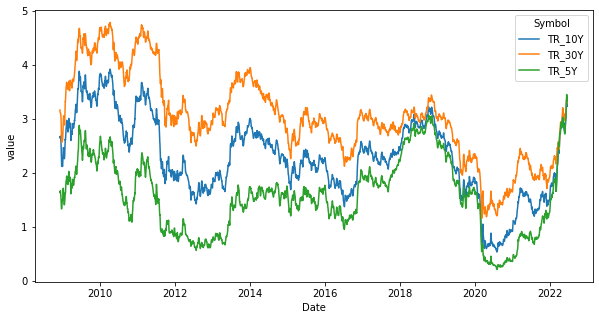

In [296]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_tr.melt(id_vars='Date'), x='Date', y='value', hue='Symbol')


## Valuation

### TODO: Improve revenue forecasting!

VaR ? simultaneous forecasting for several, competitive companies???

## ML Model for Revenue Forecasting - Postponed

Models tend to exhibit mean reversion. That is good for conservatice stocks (like coca cola, exxon, etc.)
But for growth stocks, this destroys everything. The model breaks any trend and assumes flat revenue growth rates after a few quarters.

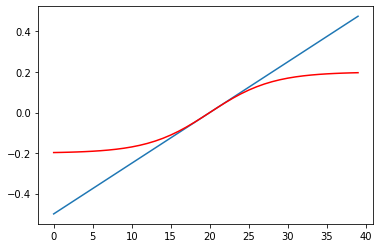

In [297]:
# Growth rate capping
# Adjust low and very high growth rates

gr = np.arange(-.5, .5, 0.025)

# https://en.wikipedia.org/wiki/Logistic_function
def log_curve(x, k, x_0 = 0, L = 1, c = 0):
    return L / (1 + np.exp(-k * (x - x_0))) + c

# Optimize k parameter!
gr_adj = [log_curve(x = i, k = 10, L = .4, c = -.2) for i in gr]

plt.plot(gr)
plt.plot(gr_adj, color='red')

In [298]:
# Inspect historic growth rates -> cap too high growth rates! there are some jumps where growth rate is too high
# df_fundamentals['Rev_SUM'] = df_fundamentals.groupby('Symbol')['Revenue'].rolling(4, min_periods=4).sum().reset_index(drop=True)

# # df_fundamentals.head()
# df_fundamentals['Rev_SUM_lag'] = df_fundamentals.groupby('Symbol')['Rev_SUM'].shift()

# gr_hist = df_fundamentals['Rev_SUM'] / df_fundamentals['Rev_SUM_lag'] -1
# plt.hist(gr_hist)

In [299]:
# Revenue forecasting

# def growth_rate_yoy(x):
#     x_1 = np.sum(x[4:])
#     x_0 = np.sum(x[:4])

#     if x_0 == 0:
#         return 0
#     else:
#         return (x_1 / x_0) - 1

def growth_rate_forecast(x):

    # Average Annual Growth Rate (AAGR)
    # window_length = 8

    # gr = []

    # for i in range(len(x) - window_length):
        
    #     gr_i = growth_rate_yoy(x[i:(window_length+i)])
    #     gr.extend([gr_i])

    # Year on Year -> Q4/Q4 growth rates -> with highest weight on recent observations!
    gr = [(i / j) - 1 for i,j in zip(x[3:], x[:-3])]

    # Cap growth rates to (-0.2, 0.2)
    gr = [min(0.2, max(-0.2, i)) for i in gr]

    # Uniformly weighted average
    # gr_mean = np.mean(gr)

    # Overweight last observations
    gr_mean = np.average(gr, weights=np.arange(1, len(gr) + 1))

    return gr_mean

def revenue_forecast(rev, n_periods):
    '''Forecast revenue'''

    # Determine anchor point for forecast
    # Take average due to seasonality; for now.
    rev_t0 = np.mean(rev[-4:])

    # Forecast growth rate of revenue
    gr = growth_rate_forecast(rev)

    # Preparation
    index = np.arange(0, n_periods, 1) + 1

    # Forecast for 10 years, i.e. 10*4 periods
    rev_fc = np.full((1, n_periods), rev_t0)

    gr_fc = np.full((1, n_periods), gr)

    # Translate yearly growth rate to quarterly rate
    gr_fc_q = (1 + gr_fc)**(1/4) - 1

    # Introduce diminising growth rates
    # TODO: punish negative growth rates more than positive ones?
    if gr < 0:
        gr_fc_q = gr_fc_q * np.power(0.90, index)
    else:
        gr_fc_q = gr_fc_q * np.power(0.99, index)    

    rev_fc = rev_fc * np.power((1 + gr_fc_q), index)
    
    return rev_fc[0]

revenue_forecast([*range(10, 20, 1)], 5)

array([18.29613694, 19.11184946, 19.94680847, 20.80064818, 21.67296671])

In [300]:
# Cost Forecasting

def cost_forecast(tax_rate, cost_rate):

    # On median, there is a 20% tax rate, meaning 80% of revenue is cost
    # return 0.8
    # return (1 - np.sum(inc) / np.sum(rev))

    # But, the tax rate changed over time.
    return tax_rate + cost_rate

    

In [301]:
# Inspect average tax rates
df_temp = df_fundamentals.assign(tax_rate = lambda x: -x['Income Taxes'] / x['Pre-Tax Income'])
# sns.histplot(data=df_temp, x='tax_rate')
# df_temp.tax_rate.describe()

# Tax_rate vs revenue!
# sns.scatterplot(data=df_temp[df_temp.tax_rate.between(-.25, .5)], x='Revenue', y='tax_rate')

# TODO: Tax_rate over time! It decreases from 25% to 19% -> Financial crisis + Trump :D
# sns.scatterplot(data=df_temp[df_temp.tax_rate.between(-.25, .5)], x='Y_Q', y='tax_rate')
# df_temp[df_temp.tax_rate.between(-.25, .5)].groupby('Y_Q')['tax_rate'].median().plot()

df_fundamentals['Tax_Rate'] = df_temp.groupby('Symbol').tax_rate.expanding().median().reset_index(drop=True)

In [302]:
# Average Costs before tax
df_temp = df_fundamentals.assign(cost_rate = lambda x: x['Pre-Tax Income'] / x['Revenue'])

# sns.histplot(data=df_temp, x='cost_rate')
# df_temp.groupby('Symbol').cost_rate.describe()

df_fundamentals['Cost_Rate'] = df_temp.groupby('Symbol').cost_rate.expanding().median().reset_index(drop=True)

In [303]:
# Revenue forecastsing model -> Backtesting and validation infrastructure!!!

# Collect all returns
df_pred_coll = pd.DataFrame()

for sym in fundamentals.keys():

    df_pred = df_fundamentals[df_fundamentals.Symbol == sym].copy()
    # df_pred['Y_Q_Base'] = df_pred['Y_Q']

    # y_q_start = '2022-01-01'
    n_periods = 40

    for y_q_start in df_pred.Y_Q[-10:]:

        # Create dataframe of revenues
        df_pred_i = pd.DataFrame(pd.Series(pd.date_range(y_q_start, periods=n_periods, freq='Q')), columns=['Y_Q'])
        df_pred_i['Y_Q_Base'] = y_q_start

        df_pred_i['Y_Q'] = pd.PeriodIndex(df_pred_i.Y_Q, freq = 'Q').to_timestamp()

        df_pred_i['Symbol'] = sym

        # Extract data for forecast -> last 8 quarters?
        i_y_q_start = np.where(df_pred.Y_Q == y_q_start)[0]
        i_y_q_start = int(i_y_q_start)
        idx = [i for i in range(i_y_q_start - 12, i_y_q_start)]
        df_i = df_pred.iloc[idx,]

        # Extract values for forecast
        rev = df_i['Revenue']
        inc = df_i['Net Income']

        tax_rate = df_i['Tax_Rate'] 
        cost_rate = df_i['Cost_Rate'] 

        # Average of last x quarters is anker point for forecast
        cost_avg = cost_forecast(tax_rate, cost_rate)

        # Forecast revenue
        rev_fc = revenue_forecast(rev, n_periods)

        # Enter forecasted values
        df_pred_i['Rev_FC'] = [*list(rev_fc)]

        # Calculate net income
        df_pred_i['Net_Inc_FC'] = [i * (1 - cost_avg) for i in df_pred_i['Rev_FC']]

        df_pred_coll = df_pred_coll.append(df_pred_i)

df_pred_coll = df_pred_coll.reset_index(drop=True)
df_pred_coll.tail()

,Y_Q,Y_Q_Base,Symbol,Rev_FC,Net_Inc_FC
8395,2031-01-01,2022-04-01,XOM,156289.231383,1457 85307.808002 1458 85347.466488 1459...
8396,2031-04-01,2022-04-01,XOM,158168.001445,1457 86333.302557 1458 86373.437782 1459...
8397,2031-07-01,2022-04-01,XOM,160020.690421,1457 87344.561197 1458 87385.166543 14...
8398,2031-10-01,2022-04-01,XOM,161846.638852,1457 88341.223966 1458 88382.292647 14...
8399,2032-01-01,2022-04-01,XOM,163645.220007,1457 89322.948775 1458 89364.473847 14...


<AxesSubplot:xlabel='Y_Q', ylabel='Revenue'>

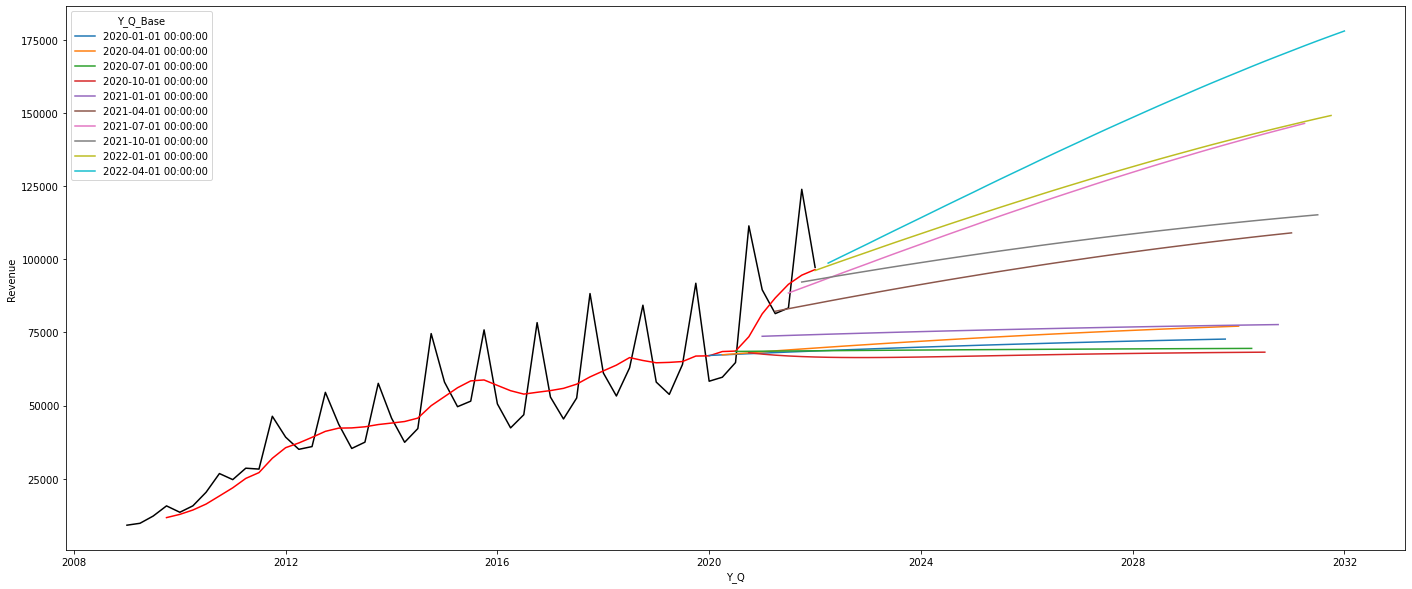

In [304]:
# Plot for each symbol
sym = 'AAPL'
fig, ax = plt.subplots(figsize=(24,10))
df_plot = df_fundamentals[df_fundamentals.Symbol == sym].copy()
df_plot['Rev_MA'] = df_plot['Revenue'].rolling(4, min_periods=4).mean()
sns.lineplot(data=df_plot, x='Y_Q', y='Revenue', color='black')
sns.lineplot(data=df_plot, x='Y_Q', y='Rev_MA', color='red')
sns.lineplot(data=df_pred_coll.loc[df_pred_coll.Symbol == sym], x='Y_Q', y='Rev_FC', hue='Y_Q_Base')
# g = sns.FacetGrid(df_pred_coll, col="Symbol", height=3, col_wrap=5)
# g.map(sns.lineplot, 'Y_Q', 'Rev_FC', 'Y_Q_Base')


In [305]:
# Growth rate as: last 4 quarter divided by previous 4 quarters
# gr_rate = lambda x: (x[4:].sum() / x[:4].sum()) - 1

# df_fundamentals['Rev_growth'] = df_fundamentals.groupby(['Symbol'])[['Revenue']].transform(lambda x: x.rolling(8, s=8).apply(gr_rate))
# df_fundamentals.dropna(subset=['Rev_growth']).tail(10)


In [306]:
# Calculate expected revenue of next 10 years

# Store time series as list

# https://stackoverflow.com/questions/47482009/pandas-rolling-window-to-return-an-array - THANK YOU!
n_hist_periods = 12
df_fundamentals['Rev_List'] = [window.to_list() for window in df_fundamentals.groupby('Symbol')['Revenue'].rolling(n_hist_periods, min_periods=n_hist_periods)]
df_fundamentals['Inc_List'] = [window.to_list() for window in df_fundamentals.groupby('Symbol')['Net Income'].rolling(n_hist_periods, min_periods=n_hist_periods)]

# Calculate moving averages of revenue and income
df_fundamentals['Rev_MA'] = df_fundamentals.groupby('Symbol')['Revenue'].rolling(4, min_periods=4).mean().reset_index(drop=True)
df_fundamentals['Rev_SUM'] = df_fundamentals.groupby('Symbol')['Revenue'].rolling(4, min_periods=4).sum().reset_index(drop=True)

df_fundamentals['Inc_MA'] = df_fundamentals.groupby('Symbol')['Net Income'].rolling(4, min_periods=4).mean().reset_index(drop=True)
df_fundamentals['Inc_SUM'] = df_fundamentals.groupby('Symbol')['Net Income'].rolling(4, min_periods=4).sum().reset_index(drop=True)

df_val = df_prices.set_index('Date').join(df_tr.set_index('Date'), on=['Date']).reset_index()

# Add rev + rev_growth
col_sel = ['Rev_List', 'Shares Outstanding', 'Inc_List', 'Revenue', 'Net Income', 'Rev_MA', 'Rev_SUM', 'Inc_MA', 'Inc_SUM', 'Tax_Rate', 'Cost_Rate']

df_val = df_val.join(df_fundamentals[['Symbol', 'Y_Q', *col_sel]].rename(columns={'Y_Q':'Date'}).set_index(['Date', 'Symbol']), on=['Date', 'Symbol'])

# Fill revenue + rev-growth forward
df_val[col_sel] = df_val.groupby('Symbol')[col_sel].ffill()

df_val.head()



,Date,Symbol,Close,TR_10Y,TR_30Y,TR_5Y,Rev_List,Shares Outstanding,Inc_List,Revenue,Net Income,Rev_MA,Rev_SUM,Inc_MA,Inc_SUM,Tax_Rate,Cost_Rate
0,2008-12-01,AAPL,3.176071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-12-02,AAPL,3.302500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-12-03,AAPL,3.425000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-12-04,AAPL,3.264643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-12-05,AAPL,3.357143,2.663,3.1632,1.6456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
# Calculate revenue forecast and dcf

def calc_dcf_wrapper(x):

    # Extract values for forecast
    rev = x['Rev_List']
    inc = x['Inc_List']

    tax_rate = x['Tax_Rate'] 
    cost_rate = x['Cost_Rate'] 

    r_disc = x['TR_10Y']

    if np.sum(np.isnan(rev)) != 0:
        dcf_rev, dcf_inc, rev_fc, inc_fc, cost_avg = np.nan, np.nan, [np.nan], [np.nan], np.nan
    else:
        dcf_rev, dcf_inc, rev_fc, inc_fc, cost_avg = calc_dcf(rev, inc, r_disc, 40, tax_rate, cost_rate)

    x['Rev_dcf'] = dcf_rev
    x['Inc_dcf'] = dcf_inc

    x['Rev_fc'] = rev_fc
    x['Inc_fc'] = inc_fc

    x['Cost_Avg'] = cost_avg

    return x

def calc_dcf(rev, inc, r_disc, n_periods, tax_rate, cost_rate):

    # Preparation
    index = np.arange(0, n_periods, 1) + 1

    # Average of last x quarters is anker point for forecast
    cost_avg = cost_forecast(tax_rate, cost_rate)

    # # Forecast revenue
    rev_fc = revenue_forecast(rev, n_periods)
    inc_fc = rev_fc * (1 - cost_avg)

    # DCF calculations ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Floor disctount rate to 1% p.a.
    r_disc = max(r_disc / 100, 0.01)

    # Yearl to quarterly rate
    tr_q = (1 + r_disc)**(1/4) - 1
    disc = np.full((1, n_periods), tr_q) # TODO: mix different treausry rates + forecast?    

    # Apply discount factor and sum
    dcf_rev = np.sum(rev_fc / np.power((1 + disc), index)) # **(1/4)

    dcf_inc = np.sum(inc_fc / np.power((1 + disc), index)) # **(1/4)

    # Gordon Growth Model ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # gr = growth_rate_forecast(rev)
    # gr_q = (1 + gr)**(1/4) - 1
    # # Translate discount factor to rate -> 3.1 / 100 !!!
    # tr_q = (1 + r_disc/100)**(1/4) - 1

    # # Cost of capital, i.e. tr_q must always be larger than gr_q, otherwise the model breaks
    # tr_q = max(tr_q, gr_q + 0.001)    

    # rev_t0 = np.mean(rev[-4:])

    # dcf_rev = (rev_t0 * (1 + gr_q)) / (tr_q - gr_q)
    # dcf_inc = dcf_rev * cost_avg


    return dcf_rev, dcf_inc, rev_fc, inc_fc, cost_avg


In [308]:
# Apply on all rows
df_val = df_val[df_val.Date >= '2015-01-01'].apply(calc_dcf_wrapper, axis=1)

## For different stocks, calcaulte rev_exp / price over all periods -> check distribution to infer parameters!

In [309]:
df_val['Rev_dcf_price'] = df_val['Rev_dcf'] / df_val['Shares Outstanding'] / df_val['Close']
df_val['Inc_dcf_price'] = df_val['Inc_dcf'] / df_val['Shares Outstanding'] / df_val['Close']
df_val['Inc_dcf_per_share'] = df_val['Inc_dcf'] / df_val['Shares Outstanding']

In [310]:
# TODO: normalize for each symbol? -> make comparable!
# # TODO: THE FUCK IS WRONG WITH NFLX?
# fig, ax = plt.subplots(figsize=(16,10))
# sns.histplot(data=df_val, x='Rev_dcf_price', hue='Symbol')

In [311]:
# fig, ax = plt.subplots(figsize=(16,10))
# sns.histplot(data=df_val, x='Inc_dcf_price', hue='Symbol')
# g = sns.FacetGrid(data=df_val, col='Symbol', col_wrap=5)
# g.map(sns.histplot, 'Inc_dcf_price')

In [312]:
# Forward PE Ratio
# df_val = df_val.assign(PE_ratio = lambda x: (x['Close'] / (x['Inc_SUM'] / x['Shares Outstanding'])))

# g = sns.FacetGrid(data=df_val, col='Symbol', col_wrap=5)
# g.map(sns.histplot, 'PE_ratio')

def FPE_extract(x):

    x['Forward_Eearnings'] = sum(x['Inc_fc'][:3])
    return x

df_val = df_val.apply(FPE_extract, axis=1)
# df_val.loc[~np.isnan(df_val.Rev_dcf)].head()

<AxesSubplot:xlabel='Inc_SUM', ylabel='Forward_Eearnings'>

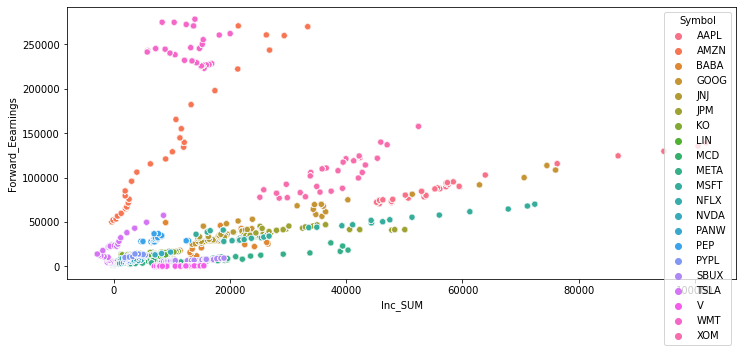

In [313]:
fig, ax = plt.subplots(figsize=(12,5))
sns.scatterplot(data=df_val, x='Inc_SUM', y='Forward_Eearnings', hue='Symbol')

In [314]:
# Forward Price Earnings

df_val = df_val.assign(FPE = lambda x: x['Forward_Eearnings'] / x['Shares Outstanding'] / x['Close'])

df_val.groupby('Symbol')['FPE'].describe().head()


,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
AAPL,2647.0,0.090528,0.027237,0.040102,0.065229,0.093983,0.109564,0.148552
AMZN,2647.0,0.174371,0.040384,0.109486,0.148618,0.165372,0.184943,0.375336
BABA,1826.0,0.046802,0.025912,0.017903,0.026672,0.043753,0.051171,0.160349
GOOG,2647.0,0.061719,0.006795,0.047465,0.057470,0.061140,0.065258,0.089169
JNJ,2647.0,0.091252,0.006311,0.079120,0.085949,0.090248,0.095905,0.115809


In [315]:
df_val.groupby('Symbol')['Cost_Avg'].describe().head()

,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
AAPL,2647.0,0.550605,0.010140,0.535071,0.539778,0.553643,0.558426,0.562889
AMZN,2647.0,0.306739,0.018740,0.275883,0.292140,0.305507,0.321942,0.336433
BABA,1826.0,0.582070,0.035208,0.528916,0.555317,0.567697,0.617878,0.644785
GOOG,2647.0,0.490879,0.018893,0.472606,0.475409,0.488925,0.495061,0.538414
JNJ,2647.0,0.455051,0.010811,0.435922,0.445753,0.458741,0.462811,0.474204


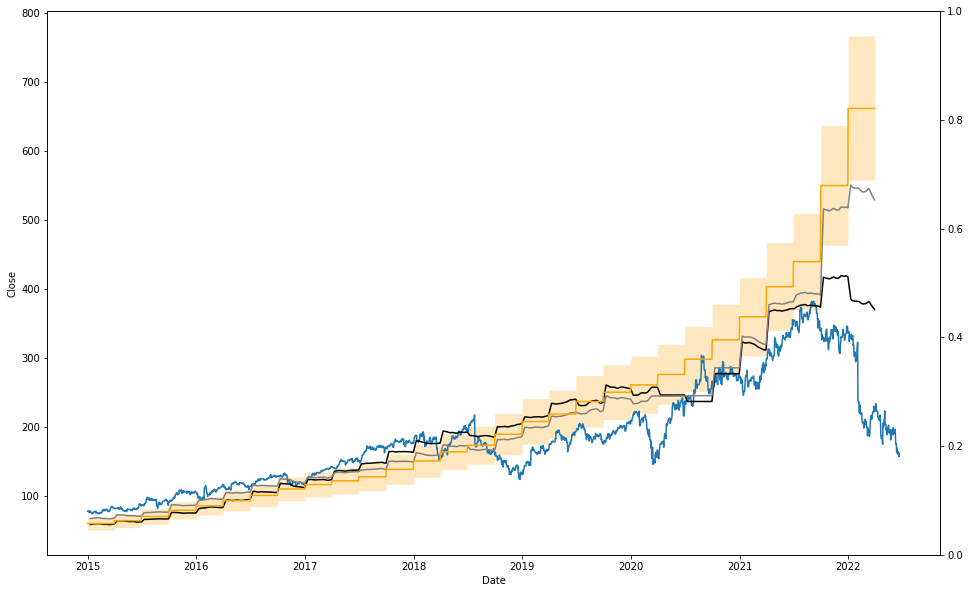

In [321]:
# Sector specific quantiles?

# TODO: Shiller PE -> can we get that as external data? Price / Forward PE?

sym = 'META'

df_plot = df_val[df_val.Symbol==sym]

df_plot = df_plot.assign(
    val_Rev = lambda x: x['Rev_dcf'] / x['Shares Outstanding'] / np.nanquantile(df_plot.Rev_dcf_price, .5),
    val_Inc = lambda x: x['Inc_dcf'] / x['Shares Outstanding'] / np.nanquantile(df_plot.Inc_dcf_price, .5)
)

df_plot['val_Rev_MA'] = df_plot['val_Rev'].rolling(10).mean()
df_plot['val_Inc_MA'] = df_plot['val_Inc'].rolling(10).mean()

# PE - Ratios
df_plot = df_plot.assign(
    val_PFE_low = lambda x: x['Forward_Eearnings'] / x['Shares Outstanding'] / np.nanquantile(df_plot.FPE, .4),
    val_PFE_mid = lambda x: x['Forward_Eearnings'] / x['Shares Outstanding'] / np.nanquantile(df_plot.FPE, .5),
    val_PFE_high = lambda x: x['Forward_Eearnings'] / x['Shares Outstanding'] / np.nanquantile(df_plot.FPE, .6)
)

# Actual values
df_plot = df_plot.assign(
    val_PE = lambda x: x['Net Income'] / x['Shares Outstanding'],
   
)

df_plot['val_PE'] = df_plot['val_PE'].rolling(120, min_periods=120).mean()

fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()
sns.lineplot(data=df_plot, x='Date', y='Close', ax=ax1)
# Fair Value
sns.lineplot(data=df_plot, x='Date', y='val_Rev_MA', color='black', ax=ax1)
sns.lineplot(data=df_plot, x='Date', y='val_Inc_MA', color='gray', ax=ax1)
# PE Ratios
sns.lineplot(data=df_plot, x='Date', y='val_PFE_mid', color='orange', ax=ax1)
ax1.fill_between(df_plot.Date, df_plot.val_PFE_low, df_plot.val_PFE_high, alpha=.25, linewidth=0, color='orange')
# Acutal Net Income
# sns.lineplot(data=df_plot, x='Date', y='val_PE', color='red', ax=ax2)
# Interest Rates
# sns.lineplot(data=df_plot, x='Date', y='TR_10Y', color='red', ax=ax2)

## Obervations

Problem of Growth vs Value stocks:
* High growth rates are overrated for growth stocks and taken with high cautio for value stocks.
    * Need different parameters for growth vs value vs other stocks!

Need to wrap the whole model into single function so that we can optimize parameters numerically???

In [320]:
# # Inspect the data
# sym = 'AAPL'
# pd.options.display.max_rows = 999

# df_plot = df_val[df_val.Symbol==sym]

# df_plot[df_plot.Date.between('2018-06-01', '2019-01-01')][['Date', 'Rev_dcf', 'TR_10Y', 'Shares Outstanding']]

## Scenario simulation

Simulate different interest and valuation scenarios

* Intrest rate of 4 or 5% !!!
* Growth rate -> normal vs pessimistic vs very pessimistic scenario

Idea: For different interest rate scenarios, if the company's revenue keeps growing at the last rate, what is the most probable price?

In [318]:
# Simulate next 5 years

# Iteratively add revenues for next 5*4 quarters

# TODO

# Assume different interest rates! 

# TODO

# Display range of expected valuation